# Data Preprocessing

Load RNA and labels table

In [1]:
import pandas as pd

rna_path = r"C:\Users\glori\Desktop\Lung-Cancer\Data\multiomics_rna_logCPM_TMM.tsv"
labels_path = r"C:\Users\glori\Desktop\Lung-Cancer\Data\multiomics_labels.tsv"

rna = pd.read_csv(rna_path, sep="\t")
labels = pd.read_csv(labels_path, sep="\t")

print("RNA shape:", rna.shape)
print("Labels shape: ", labels.shape)

labels.head(3)

RNA shape: (831, 17811)
Labels shape:  (831, 3)


,patient_id,subtype,subtype_simple
0,TCGA-MP-A4SV,TCGA-LUAD,LUAD
1,TCGA-55-8621,TCGA-LUAD,LUAD
2,TCGA-MN-A4N1,TCGA-LUAD,LUAD


In [2]:
rna.head(3)

,patient_id,ENSG00000000003.15,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288558.2,ENSG00000288559.1,ENSG00000288573.1,ENSG00000288586.1,ENSG00000288596.2,ENSG00000288612.1,ENSG00000288658.1,ENSG00000288663.1,ENSG00000288670.1,ENSG00000288675.1
0,TCGA-MP-A4SV,5.394902,4.952867,4.235412,3.557212,4.204274,5.350455,5.315406,3.271355,5.631599,...,2.751742,0.188592,-2.012494,-1.242265,2.033812,-0.160296,-1.242265,0.591551,3.140154,-1.433431
1,TCGA-55-8621,5.106508,4.469044,3.573832,2.163817,6.016368,6.293136,5.263294,4.924332,4.504391,...,2.917846,-0.084095,-1.343521,-1.265239,1.589195,-0.381584,-0.811372,-0.604431,1.710388,-1.707610
2,TCGA-MN-A4N1,6.038168,4.933833,3.890689,3.051575,3.176808,5.026605,5.884609,5.471267,4.950593,...,2.620192,-0.304021,-2.398258,-0.921286,1.278893,0.535144,0.743860,0.101850,1.889364,0.076356


Merge RNA with labels

In [3]:
rna_labeled = rna.merge(labels, on="patient_id")

print("Merged shape: ", rna_labeled.shape)
rna_labeled.head(3)

Merged shape:  (831, 17813)


,patient_id,ENSG00000000003.15,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288573.1,ENSG00000288586.1,ENSG00000288596.2,ENSG00000288612.1,ENSG00000288658.1,ENSG00000288663.1,ENSG00000288670.1,ENSG00000288675.1,subtype,subtype_simple
0,TCGA-MP-A4SV,5.394902,4.952867,4.235412,3.557212,4.204274,5.350455,5.315406,3.271355,5.631599,...,-2.012494,-1.242265,2.033812,-0.160296,-1.242265,0.591551,3.140154,-1.433431,TCGA-LUAD,LUAD
1,TCGA-55-8621,5.106508,4.469044,3.573832,2.163817,6.016368,6.293136,5.263294,4.924332,4.504391,...,-1.343521,-1.265239,1.589195,-0.381584,-0.811372,-0.604431,1.710388,-1.707610,TCGA-LUAD,LUAD
2,TCGA-MN-A4N1,6.038168,4.933833,3.890689,3.051575,3.176808,5.026605,5.884609,5.471267,4.950593,...,-2.398258,-0.921286,1.278893,0.535144,0.743860,0.101850,1.889364,0.076356,TCGA-LUAD,LUAD


In [4]:
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [5]:
# 1) Gene columns = everything except id + labels
gene_cols = [c for c in rna_labeled.columns 
             if c not in ["patient_id", "subtype", "subtype_simple"]]

X_genes = rna_labeled[gene_cols]
y_str   = rna_labeled["subtype_simple"]

In [6]:
# 2) Split into LUAD vs LUSC groups
luad_mask = (y_str == "LUAD")
lusc_mask = (y_str == "LUSC")

X_luad = X_genes[luad_mask]
X_lusc = X_genes[lusc_mask]

In [7]:
# 3) Log2 fold change for each gene
eps = 1e-6
mean_luad = X_luad.mean(axis=0) + eps
mean_lusc = X_lusc.mean(axis=0) + eps

log2fc = np.log2(mean_luad) - np.log2(mean_lusc)

c:\Users\glori\.conda\envs\prompEng310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# 4) t-test for each gene
pvals = []
for g in gene_cols:
    t_stat, p_val = ttest_ind(X_luad[g], X_lusc[g], equal_var=False)
    pvals.append(p_val)

pvals = np.array(pvals)

In [9]:
# 5) FDR correction (Benjamini–Hochberg)
_, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")

In [10]:
# 6) Put results into a DataFrame
deg_df = pd.DataFrame({
    "gene": gene_cols,
    "log2FC": log2fc.values,
    "pval": pvals,
    "padj": pvals_fdr
})

In [11]:
# 7) Filter for DEGs
deg_df_filt = deg_df[
    (deg_df["padj"] < 0.05) &
    (deg_df["log2FC"].abs() >= 1.0)  
].sort_values("padj")

print("Number of DEGs found:", deg_df_filt.shape[0])
deg_df_filt.head()

Number of DEGs found: 940


,gene,log2FC,pval,padj
12692,ENSG00000186081.12,-2.871807,3.507743e-219,6.247290e-215
1097,ENSG00000073282.14,-1.882309,1.383671e-177,6.160797e-174
14043,ENSG00000205420.11,-2.698792,6.701716e-171,1.989293e-167
1516,ENSG00000086570.12,-3.982907,7.797494e-167,1.983905e-163
6437,ENSG00000137699.17,-1.580875,1.820962e-152,3.243134e-149


In [12]:
# Choose top 50 DEGs
top_genes = deg_df_filt["gene"].head(50).tolist()
print("Top 50 genes:", top_genes)

Top 50 genes: ['ENSG00000186081.12', 'ENSG00000073282.14', 'ENSG00000205420.11', 'ENSG00000086570.12', 'ENSG00000137699.17', 'ENSG00000163032.12', 'ENSG00000121552.4', 'ENSG00000081277.13', 'ENSG00000131781.13', 'ENSG00000186832.9', 'ENSG00000128422.17', 'ENSG00000206075.14', 'ENSG00000236699.9', 'ENSG00000168453.15', 'ENSG00000101144.13', 'ENSG00000114270.17', 'ENSG00000183347.15', 'ENSG00000143365.19', 'ENSG00000148053.17', 'ENSG00000156049.7', 'ENSG00000167183.3', 'ENSG00000175556.17', 'ENSG00000205517.13', 'ENSG00000175984.15', 'ENSG00000168306.13', 'ENSG00000136352.19', 'ENSG00000087494.16', 'ENSG00000161243.9', 'ENSG00000130768.15', 'ENSG00000240694.9', 'ENSG00000070731.11', 'ENSG00000203697.12', 'ENSG00000103534.17', 'ENSG00000223573.7', 'ENSG00000114948.13', 'ENSG00000188959.9', 'ENSG00000196260.5', 'ENSG00000165215.6', 'ENSG00000124664.11', 'ENSG00000169860.7', 'ENSG00000184156.17', 'ENSG00000204385.13', 'ENSG00000117407.17', 'ENSG00000129194.8', 'ENSG00000196754.13', 'ENSG000

Separate features (X) and labels (y)

- X = matrix of numbers (patients X genes)
- y = vector of labels (LUAD/LUSC, will later be encoded as 0/1)

In [13]:
from sklearn.preprocessing import LabelEncoder

feature_cols = [c for c in rna_labeled.columns
                if c not in ["patient_id", "subtype", "subtype_simple"]]

# build reduced feature matrix
X = rna_labeled[top_genes].values      # (831, 50)
y_str = rna_labeled["subtype_simple"].values

print("X Shape: ", X.shape)
print("First 5 labels: ", y_str[:5])

X Shape:  (831, 50)
First 5 labels:  ['LUAD' 'LUAD' 'LUAD' 'LUAD' 'LUAD']


Encode the labels

In [14]:
le = LabelEncoder()
y = le.fit_transform(y_str)

print("Class mapping: ", dict(zip(le.classes_, le.transform(le.classes_))))
print("Y[:10]:", y[:10])

Class mapping:  {'LUAD': np.int64(0), 'LUSC': np.int64(1)}
Y[:10]: [0 0 0 0 0 0 0 0 0 0]


Train/Test split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (664, 50) Test: (167, 50)


Standardize the features

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Model Training

# Logistic Regression

Predicts the probability of an event occuring by using a sigmoid function to map a linear combination of input variables to an output between 0 and 1

### Train

In [17]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    penalty="l2",
    solver="saga",
    max_iter=5000,
    n_jobs=-1
)

logreg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,5000
,multi_class,'deprecated'


### Make predictions

In [18]:
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

### Evaluate the model

#### Accuracy

In [19]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)

print("Accuracy: ", acc)

Accuracy:  0.9580838323353293


#### Confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:")
print(cm)

Confusion matrix:
[[89  3]
 [ 4 71]]


#### Classification report

In [21]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

        LUAD       0.96      0.97      0.96        92
        LUSC       0.96      0.95      0.95        75

    accuracy                           0.96       167
   macro avg       0.96      0.96      0.96       167
weighted avg       0.96      0.96      0.96       167



#### ROC Curve and AUC

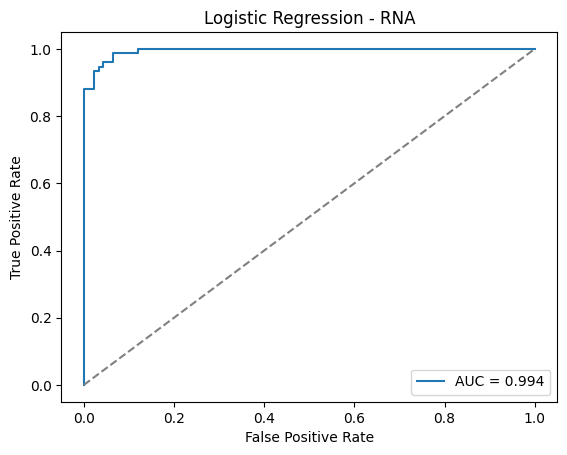

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - RNA')
plt.legend()
plt.show()

## Linear Discriminant Analysis (LDA) 

LDA tries to find a linear combination of genes that best separates the two classes

Mathematically, it solves for a projection $w^T x$ that maximizes the separation between class means while minimizing the variation within each class

We are trying to find the "direction" in gene-expression space that best separates LUAD from LUSC.

It then classifies a test sample based on which side of the separating line it falls on

#### Train LDA

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


#### Evaluation

In [25]:
y_pred_lda = lda.predict(X_test_scaled)
y_proba_lda = lda.predict_proba(X_test_scaled)[:, 1]

##### Accuracy

In [26]:
from sklearn.metrics import accuracy_score

acc_lda = accuracy_score(y_test, y_pred_lda)

print("LDA Accuracy: ", acc_lda)

LDA Accuracy:  0.9520958083832335


##### Confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix

cm_lda = confusion_matrix(y_test, y_pred_lda)

print("LDA Confusion Matrix: ")
print(cm_lda)

LDA Confusion Matrix: 
[[90  2]
 [ 6 69]]


##### Classification Report

In [28]:
from sklearn.metrics import classification_report

print("LDA Classification report")
print(classification_report(y_test, y_pred_lda, target_names=le.classes_))

LDA Classification report
              precision    recall  f1-score   support

        LUAD       0.94      0.98      0.96        92
        LUSC       0.97      0.92      0.95        75

    accuracy                           0.95       167
   macro avg       0.95      0.95      0.95       167
weighted avg       0.95      0.95      0.95       167



##### ROC and AUC

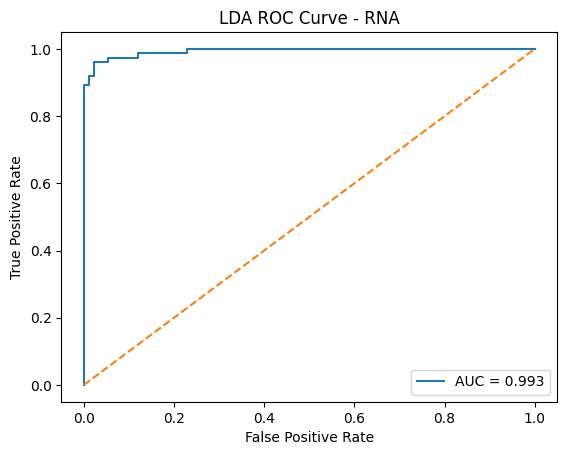

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc_lda = roc_auc_score(y_test, y_proba_lda)
fpr, tpr, thresh = roc_curve(y_test, y_proba_lda)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_lda:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LDA ROC Curve - RNA")
plt.legend()
plt.show()

# KNN

1. KKN looks at the **K Closest Samples** in the training set
2. Checks theor labels
3. Assigns the majority label among those K neighbors
$$\hat{y} = \text{majority}({y_{k\_nearest}})$$

#### Train the model

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


#### Predictions

In [32]:
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:,1]

#### Evaluate

##### Accuracy

In [33]:
from sklearn.metrics import accuracy_score

acc_knn = accuracy_score(y_test, y_pred_knn)

print("KNN Accuracy: ", acc_knn)

KNN Accuracy:  0.9401197604790419


##### Confusion matrix

In [34]:
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)

print("confusion_matrix")
print(cm_knn)

confusion_matrix
[[90  2]
 [ 8 67]]


##### Classification report

In [35]:
from sklearn.metrics import classification_report

print("Classification Report")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

Classification Report
              precision    recall  f1-score   support

        LUAD       0.92      0.98      0.95        92
        LUSC       0.97      0.89      0.93        75

    accuracy                           0.94       167
   macro avg       0.94      0.94      0.94       167
weighted avg       0.94      0.94      0.94       167



##### ROC and AUC

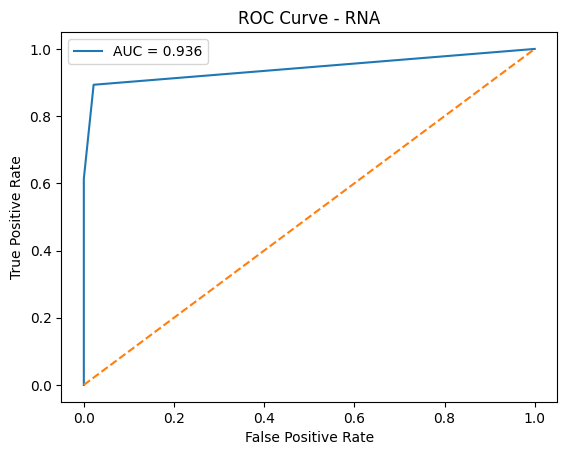

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc_knn = roc_auc_score(y_test, y_pred_knn)
fpr, tpr, th = roc_curve(y_test, y_proba_knn)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_knn:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RNA")
plt.legend()
plt.show()

# Naive Bayes

#### Train NB

In [37]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

,priors,None
,var_smoothing,1e-09


#### Predictions

In [38]:
y_pred_nb = nb.predict(X_test_scaled)
y_proba_nb = nb.predict_proba(X_test_scaled)[:,1]

#### Evaluation

##### Accuracy

In [39]:
from sklearn.metrics import accuracy_score

acc_nb = accuracy_score(y_test, y_pred_nb)

print("Naive Bayes Accuracy: ", acc_nb)

Naive Bayes Accuracy:  0.9520958083832335


##### Confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix

cm_nb = confusion_matrix(y_test, y_pred_nb)

print("Confusion Matrix")
print(cm_nb)

Confusion Matrix
[[90  2]
 [ 6 69]]


##### Classification Report

In [41]:
from sklearn.metrics import classification_report

print("Classification Report")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

Classification Report
              precision    recall  f1-score   support

        LUAD       0.94      0.98      0.96        92
        LUSC       0.97      0.92      0.95        75

    accuracy                           0.95       167
   macro avg       0.95      0.95      0.95       167
weighted avg       0.95      0.95      0.95       167



##### ROC and AUC

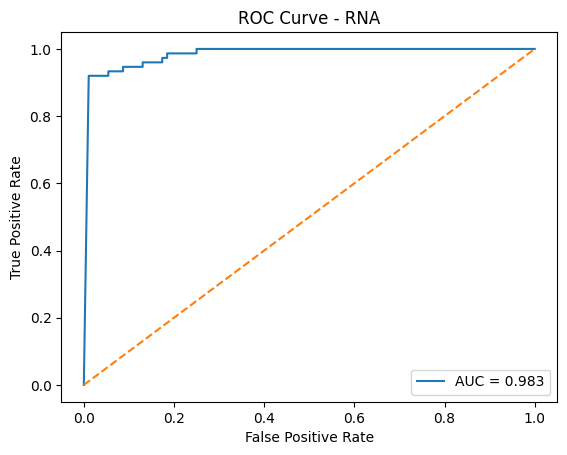

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc_nb = roc_auc_score(y_test, y_proba_nb)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_nb)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_nb:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RNA")
plt.legend()
plt.show()

# Decision Tree - CART

#### Train the model

In [43]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    random_state=42
)

dt.fit(X_train_scaled, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### Predictions

In [44]:
y_pred_dt = dt.predict(X_test_scaled)
y_proba_dt = dt.predict_proba(X_test_scaled)[:, 1]

#### Evaluations

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc_dt = accuracy_score(y_test, y_pred_dt)
cm_dt  = confusion_matrix(y_test, y_pred_dt)

print("Decision Tree Accuracy:", acc_dt)
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, target_names=le.classes_))
print("\nConfusion Matrix:\n", cm_dt)

Decision Tree Accuracy: 0.9101796407185628

Classification Report:
               precision    recall  f1-score   support

        LUAD       0.96      0.87      0.91        92
        LUSC       0.86      0.96      0.91        75

    accuracy                           0.91       167
   macro avg       0.91      0.91      0.91       167
weighted avg       0.92      0.91      0.91       167


Confusion Matrix:
 [[80 12]
 [ 3 72]]


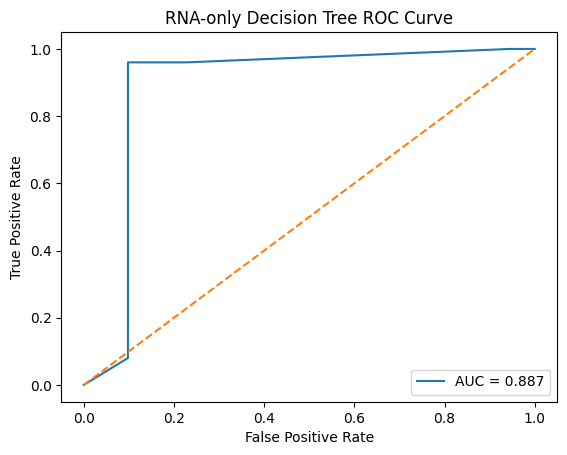

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc_dt = roc_auc_score(y_test, y_proba_dt)
fpr, tpr, th = roc_curve(y_test, y_proba_dt)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_dt:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RNA-only Decision Tree ROC Curve")
plt.legend()
plt.show()

In [47]:
import numpy as np

importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

top10_idx = indices[:10]
top10_genes = [top_genes[i] for i in top10_idx]  # match to your 50 DEGs

print("Top important genes:")
for g, s in zip(top10_genes, importances[top10_idx]):
    print(f"{g}: {s:.4f}")

Top important genes:
ENSG00000186081.12: 0.7988
ENSG00000175556.17: 0.0571
ENSG00000236699.9: 0.0317
ENSG00000165215.6: 0.0189
ENSG00000087494.16: 0.0168
ENSG00000086570.12: 0.0126
ENSG00000114270.17: 0.0110
ENSG00000003096.14: 0.0095
ENSG00000163032.12: 0.0077
ENSG00000129194.8: 0.0065


# Support Vector Machines

Powerful classifier that tries to find the best separating boundary between classes

**Linear SVM**
Find a hyperplane 
$$w^T x + b = 0$$
such that:
- LUAD and LUSC are separated
- The margin (distance between the plane and the closest point from eahc class) is maximized

Those closest points are the support vectors

**RBF (Radial Basis Function) kernel SVM** 

Real data is not linearly separable most of the time.

So SVM uses the kernel trick:
- Map data into a highter-dimensional feature space
- Use a kernel function to compute similarity there, without explivitly transforming the data

The **RBF kernel is:  $$K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$$ where $\gamma$ is the kernel coefficient and $\|x_i - x_j\|^2$ is the squared Euclidean distance.

- If two samples are close → large K
- If far apart → small K
- This lets SVM learn non-linear decision boundaries in the gene expression space

**Main Hyperparameters:**
- C - regularization strength
    - large C → Less regularization → fit training data more (risk of overfitting)
    - small C → more regularization → smoother boundary
- gamma - how far the influence of each sample reaches
    - large gamma → very local, flexible boundaries (overfitting)
    - small gamma → smoother, more global boundaries

#### Train an SVM with RBF kernel

In [48]:
from sklearn.svm import SVC

svm_rna = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",    # default, uses 1 / (n_features * var)
    probability=True, # so we can get predict_proba
    random_state=42
)

svm_rna.fit(X_train_scaled, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


#### Predictions

In [49]:
y_pred_svm = svm_rna.predict(X_test_scaled)
y_proba_svm = svm_rna.predict_proba(X_test_scaled)[:, 1]

#### Evaluation

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc_svm = accuracy_score(y_test, y_pred_svm)
cm_svm  = confusion_matrix(y_test, y_pred_svm)

print("SVM (RBF) Accuracy:", acc_svm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=le.classes_))
print("\nConfusion Matrix:\n", cm_svm)


SVM (RBF) Accuracy: 0.9520958083832335

Classification Report:
               precision    recall  f1-score   support

        LUAD       0.94      0.98      0.96        92
        LUSC       0.97      0.92      0.95        75

    accuracy                           0.95       167
   macro avg       0.95      0.95      0.95       167
weighted avg       0.95      0.95      0.95       167


Confusion Matrix:
 [[90  2]
 [ 6 69]]


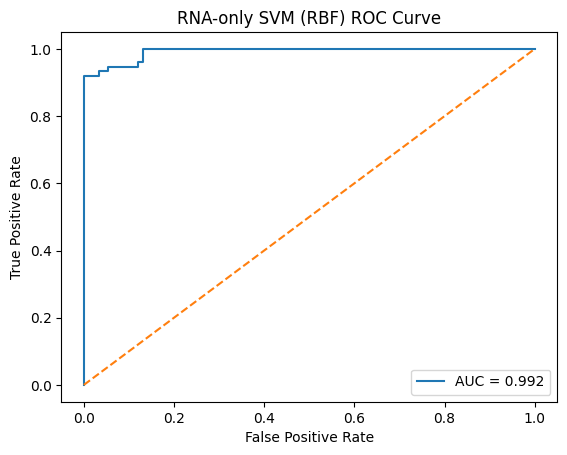

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc_svm = roc_auc_score(y_test, y_proba_svm)
fpr, tpr, thresh = roc_curve(y_test, y_proba_svm)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_svm:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RNA-only SVM (RBF) ROC Curve")
plt.legend()
plt.show()


In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.001]
}

svm_grid = GridSearchCV(
    SVC(kernel="rbf", probability=True),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

svm_grid.fit(X_train_scaled, y_train)
print("Best params:", svm_grid.best_params_)
print("Best CV accuracy:", svm_grid.best_score_)


Best params: {'C': 10, 'gamma': 0.001}
Best CV accuracy: 0.930747322852586


In [53]:
import pandas as pd

# Put your metrics here (use your actual variable names)
results = [
    {"Model": "LDA",                 "Accuracy": acc_lda,     "AUC": auc_lda},
    {"Model": "KNN (k=5)",           "Accuracy": acc_knn,     "AUC": auc_knn},
    {"Model": "Naive Bayes",         "Accuracy": acc_nb,      "AUC": auc_nb},
    {"Model": "Decision Tree (CART)","Accuracy": acc_dt,      "AUC": auc_dt},
    {"Model": "SVM (RBF)",           "Accuracy": acc_svm,     "AUC": auc_svm},
    {"Model": "Logistic Regression", "Accuracy": acc,         "AUC": auc},
]

rna_summary = pd.DataFrame(results)

# Optional: sort by Accuracy descending
rna_summary = rna_summary.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

rna_summary


,Model,Accuracy,AUC
0,Logistic Regression,0.958084,0.994493
1,LDA,0.952096,0.993478
2,SVM (RBF),0.952096,0.992029
3,Naive Bayes,0.952096,0.983261
4,KNN (k=5),0.940120,0.935797
5,Decision Tree (CART),0.910180,0.886522


In [55]:
# Round values for display
rna_summary_rounded = rna_summary.copy()
rna_summary_rounded["Accuracy"] = rna_summary_rounded["Accuracy"].round(3)
rna_summary_rounded["AUC"]      = rna_summary_rounded["AUC"].round(3)

print(rna_summary_rounded.to_markdown(index=False))


| Model                |   Accuracy |   AUC |
|:---------------------|-----------:|------:|
| Logistic Regression  |      0.958 | 0.994 |
| LDA                  |      0.952 | 0.993 |
| SVM (RBF)            |      0.952 | 0.992 |
| Naive Bayes          |      0.952 | 0.983 |
| KNN (k=5)            |      0.94  | 0.936 |
| Decision Tree (CART) |      0.91  | 0.887 |


In [56]:
# CSV
rna_summary_rounded.to_csv("unimodal_rna_summary.csv", index=False)

# LaTeX table (for Overleaf)
with open("unimodal_rna_summary.tex", "w") as f:
    f.write(rna_summary_rounded.to_latex(index=False))
